In [4]:
import pandas as pd
import random
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

## 1️⃣ Load data

In [6]:
import pandas as pd
import numpy as np


train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

## 2️⃣ Preprocessing

### (1)_ drop

In [7]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'Y_Quality', 'TIMESTAMP'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

### (2)_ LabelEncoder

In [8]:
from sklearn.preprocessing import LabelEncoder

# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


### (3)_ 새로운 Feature : null 개수

In [9]:
train_x['count_null']=train_x.isnull().sum(axis=1)
test_x['count_null']=test_x.isnull().sum(axis=1)

### (3)_ Split

In [10]:
train_x = train_x[['Y_Class', 'LINE', 'PRODUCT_CODE', 'count_null']]
test_x = test_x[['LINE', 'PRODUCT_CODE', 'count_null']]

In [11]:
# train
train_x_1 = train_x[train_x['PRODUCT_CODE'] == 0].drop('Y_Class', axis=1)
train_x_2 = train_x[train_x['PRODUCT_CODE'] != 0].drop('Y_Class', axis=1)

train_y_1 = train_x['Y_Class'][train_x['PRODUCT_CODE'] == 0]
train_y_2 = train_x['Y_Class'][train_x['PRODUCT_CODE'] != 0]

print('train_x_1 shape :', train_x_1.shape,
      '\ntrain_x_2 shape :', train_x_2.shape)

print('\ntrain_y_1 shape :', train_y_1.shape,
      '\ntrain_y_2 shape :', train_y_2.shape)



# test
test_x_1 = test_x[test_x['PRODUCT_CODE'] == 0]
test_x_2 = test_x[test_x['PRODUCT_CODE'] != 0]

print('\ntest_x_1 shape :', test_x_1.shape,
      '\ntest_x_2 shape :', test_x_2.shape)


print('done')

train_x_1 shape : (249, 3) 
train_x_2 shape : (349, 3)

train_y_1 shape : (249,) 
train_y_2 shape : (349,)

test_x_1 shape : (67, 3) 
test_x_2 shape : (243, 3)
done


### (4)_ train / valid split

In [12]:
from sklearn.model_selection import train_test_split

# 1
train_x_1, valid_x_1, train_y_1, valid_y_1= train_test_split(train_x_1, train_y_1, test_size=0.15)

# 2
train_x_2, valid_x_2, train_y_2, valid_y_2= train_test_split(train_x_2, train_y_2, test_size=0.15)

## 3️⃣ Build model

### (1)_ define model

In [13]:
# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import svm

# metric
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

rfc = RandomForestClassifier(random_state=42)
xgbc = XGBClassifier(eval_metric='mlogloss')
svmc = svm.SVC()
gbc = GradientBoostingClassifier(random_state=42)

models = [rfc, xgbc, svmc, gbc]
model_names = ['RandomForestClassifier','XGBClassifier','SVC','GradientBoostingClassifier']

### (2)_ fit, predict

In [14]:
from sklearn.model_selection import train_test_split

# 1
train_x_1, valid_x_1, train_y_1, valid_y_1= train_test_split(train_x_1, train_y_1, test_size=0.15)

# 2
train_x_2, valid_x_2, train_y_2, valid_y_2= train_test_split(train_x_2, train_y_2, test_size=0.15)


print('### model : 1 ###\n')
for idx, i in enumerate(models):
    warnings.filterwarnings('ignore')
    model = i
    model.fit(train_x_1, train_y_1)
    pred = model.predict(valid_x_1)
    print('{} :'.format(model_names[idx]), accuracy_score(pred, valid_y_1))


print('\n\n\n### model : 2 ###\n')
for idx, i in enumerate(models):
    warnings.filterwarnings('ignore')
    model = i
    model.fit(train_x_2, train_y_2)
    pred = model.predict(valid_x_2)
    print('{} :'.format(model_names[idx]), accuracy_score(pred, valid_y_2))

### model : 1 ###

RandomForestClassifier : 0.5
XGBClassifier : 0.46875
SVC : 0.46875
GradientBoostingClassifier : 0.46875



### model : 2 ###

RandomForestClassifier : 0.8444444444444444
XGBClassifier : 0.8444444444444444
SVC : 0.8444444444444444
GradientBoostingClassifier : 0.8222222222222222


### (3)_ feature importance

In [15]:
model = rfc

# 1
model.fit(train_x_1, train_y_1)
pred1 = model.predict(valid_x_1)
print(accuracy_score(pred1, valid_y_1))

model.feature_importances_

0.5


array([0.22191875, 0.        , 0.77808125])

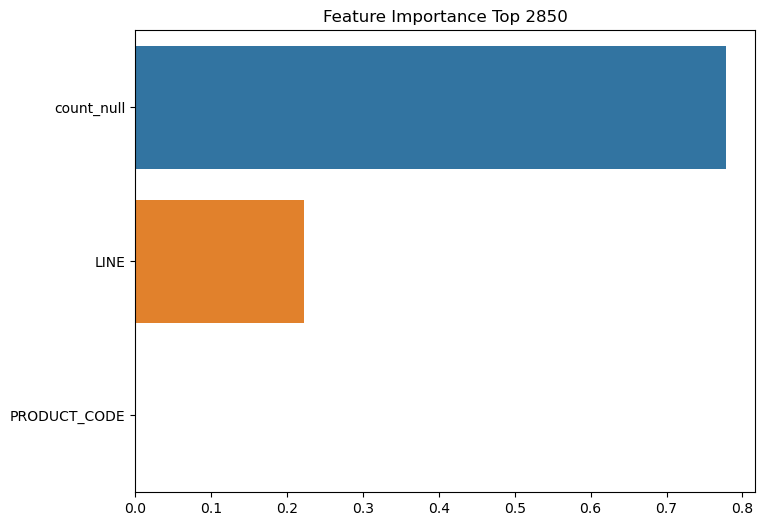

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(importance_values, index = train_x_1.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:2850]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 2850')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

## 🎯 Submit

In [52]:
# rfc, xgbc, svmc, gbc
# 'RandomForestClassifier','XGBClassifier','SVC','GradientBoostingClassifier'

model = rfc

# 1
model.fit(train_x_1, train_y_1)
pred1 = model.predict(test_x_1)

# 2
model.fit(train_x_2, train_y_2)
pred2 = model.predict(test_x_2)

In [54]:
pred_index = test_x_1.index.append(test_x_2.index)
sub_pred_value = np.concatenate([pred1, pred2])
pred = pd.DataFrame(data = sub_pred_value,
                    columns = ['Y_Class'], 
                    index = pred_index).sort_index()

submit_csv = pd.read_csv('./sample_submission.csv')
submit_csv['Y_Class'] =pred['Y_Class']
submit_csv.to_csv('0208_submission.csv', index=False)